In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
should_skip = True

In [3]:
#@title Install libraries
if not should_skip:
  !pip install -U -qq git+https://github.com/huggingface/diffusers.git
  !pip install -qq pytorch_lightning albumentations wandb gpustat gdown accelerate transformers ftfy

In [4]:
#@title Import required libraries
import argparse
import itertools
import math
import os
import random

import numpy as np
import torch
import torch.nn.functional as F
import torchvision.transforms.functional as TVF
import torch.utils.checkpoint
from torch.utils.data import Dataset

import PIL
from accelerate import Accelerator
from accelerate.logging import get_logger
from accelerate.utils import set_seed
import sys

# https://github.com/huggingface/diffusers/blob/main/src/diffusers/models/unet_2d_condition.py#L175-L182
from diffusers import AutoencoderKL, DDPMScheduler, PNDMScheduler, StableDiffusionPipeline, UNet2DConditionModel
from diffusers.optimization import get_scheduler
from diffusers.pipelines.stable_diffusion import StableDiffusionSafetyChecker
from PIL import Image
from torchvision import transforms
from tqdm.auto import tqdm
from transformers import CLIPFeatureExtractor, CLIPTextModel, CLIPTokenizer

def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

In [5]:
if not should_skip:
    #@markdown Add here the URLs to the images of the concept you are adding. 3-5 should be fine
    train_urls = [
        "https://huggingface.co/datasets/valhalla/images/resolve/main/2.jpeg",
        "https://huggingface.co/datasets/valhalla/images/resolve/main/3.jpeg",
    ]
    test_urls = [
        "https://huggingface.co/datasets/valhalla/images/resolve/main/5.jpeg",
        "https://huggingface.co/datasets/valhalla/images/resolve/main/6.jpeg",
        ## You can add additional images here
    ]
#@title Download
import requests
import glob
from io import BytesIO

def download_image(url):
  try:
    response = requests.get(url)
  except:
    return None
  return Image.open(BytesIO(response.content)).convert("RGB")

if not should_skip:
    for save_path,urls in [("./my_concept",train_urls),("./my_concept_test",test_urls)]:
      images = list(filter(None,[download_image(url) for url in urls]))
      if not os.path.exists(save_path):
        os.mkdir(save_path)
      [image.save(f"{save_path}/{i}.jpeg") for i, image in enumerate(images)]


if not should_skip:
    !gdown --id 1I8RMKQhPXntlRKorVNZ6yyNpfaOp8wNv
    mask_path="./my_concept_gt"
    !mkdir $mask_path/

    with open("my_concept_gt.zip","r") as f:
        pass
    !unzip -o my_concept_gt.zip

In [6]:
# %cd /content/
# sys.path.append("/content/slime-experiments/")

In [7]:
# !rm -rf slime-experiments/
# !git clone https://github.com/andrew-healey/slime-experiments
# !cd slime-experiments && git rev-parse --short HEAD

In [8]:
from slime.slime import SLiME
from slime.data.single_class import BinarySegmentationDataset,SegmentationDataModule

In [9]:
train_dataset = BinarySegmentationDataset(
    data_root="my_concept",
    mask_root="my_concept_gt",
)
test_dataset = BinarySegmentationDataset(
    data_root="my_concept_test",
    mask_root=None
)

data_module = SegmentationDataModule(
    train_dataset,
    test_dataset,
    iters_per_epoch=500,
    batch_size=1,
)

In [10]:
slime = SLiME(
    use_self_attn=False,
    alpha=1.0,
    gamma=1.0,
    lr=0.1,
    multiplier_lr=0.1,
    cross_attn_nums=[8]
).cuda()

/usr/local/lib/python3.8/dist-packages/diffusers/configuration_utils.py:239: FutureWarning: It is deprecated to pass a pretrained model name or path to `from_config`.If you were trying to load a scheduler, please use <class 'diffusers.schedulers.scheduling_ddpm.DDPMScheduler'>.from_pretrained(...) instead. Otherwise, please make sure to pass a configuration dictionary instead. This functionality will be removed in v1.0.0.
  deprecate("config-passed-as-path", "1.0.0", deprecation_message, standard_warn=False)


In [11]:
from pytorch_lightning import Trainer

trainer = Trainer(
    default_root_dir="run",
    limit_train_batches=1.0,
    num_sanity_val_steps=0,
    max_epochs=1,
    enable_checkpointing=False,
)

trainer.fit(slime, datamodule=data_module)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
You are using a CUDA device ('NVIDIA GeForce RTX 3060') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                   | Type            | Params
-----------------------------------------------------------
0 | sd                     | StableDiffusion | 900 M 
1 | cross_layer_multiplier | Multiplier      | 32    
2 | self_layer_multiplier  | Multiplier      | 32    
3 | cross_map_multiplier   | Multiplier      | 4     
4 | pred_map_

Training: |          | 0/? [00:00<?, ?it/s]

pred -3.11 2.79 ce loss 0.81 mse loss 0.3 dice loss 0.57
pred -2.3 1.49 ce loss 0.58 mse loss 0.2 dice loss 0.47
pred -2.92 1.89 ce loss 0.52 mse loss 0.17 dice loss 0.52
pred -3.82 2.11 ce loss 0.57 mse loss 0.2 dice loss 0.56
pred -2.53 2.0 ce loss 0.7 mse loss 0.25 dice loss 0.56
pred -2.96 2.01 ce loss 0.53 mse loss 0.18 dice loss 0.56
pred -2.94 1.24 ce loss 0.54 mse loss 0.18 dice loss 0.48
pred -3.62 2.43 ce loss 0.5 mse loss 0.16 dice loss 0.55
pred -3.12 1.08 ce loss 0.58 mse loss 0.2 dice loss 0.52
pred -3.47 1.94 ce loss 0.58 mse loss 0.2 dice loss 0.61
pred -3.56 1.73 ce loss 0.54 mse loss 0.18 dice loss 0.49
pred -5.32 2.3 ce loss 0.51 mse loss 0.17 dice loss 0.56
pred -3.86 2.11 ce loss 0.44 mse loss 0.14 dice loss 0.49
pred -3.93 2.51 ce loss 0.6 mse loss 0.21 dice loss 0.61
pred -6.17 2.0 ce loss 0.48 mse loss 0.16 dice loss 0.53
pred -4.39 1.96 ce loss 0.61 mse loss 0.21 dice loss 0.51
pred -4.9 1.8 ce loss 0.56 mse loss 0.18 dice loss 0.48
pred -4.52 1.85 ce loss 0.45

`Trainer.fit` stopped: `max_epochs=1` reached.


pred -16.27 7.78 ce loss 0.21 mse loss 0.06 dice loss 0.16


In [12]:
slime.cuda(); 0

0

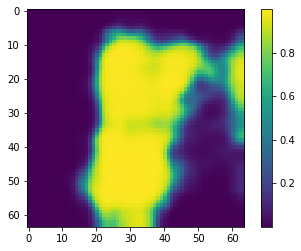

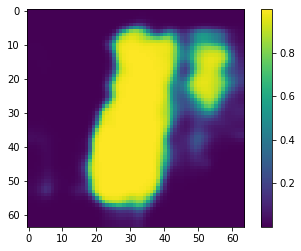

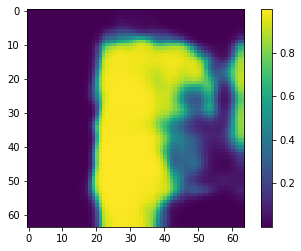

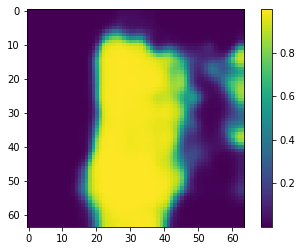

In [13]:
import matplotlib.pyplot as plt
def sigmoid(x):
    return 1 / (1 + np.exp(-x))
for i in range(4):
    a = sigmoid(slime.latest_preds[-1-i].swapaxes(1,2).reshape((-1,slime.text_tokens,64,64))[0,1])
    plt.imshow(a)
    plt.colorbar()
    plt.show()

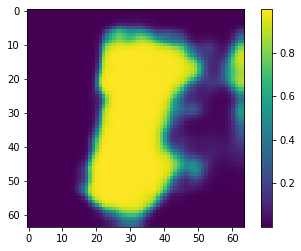

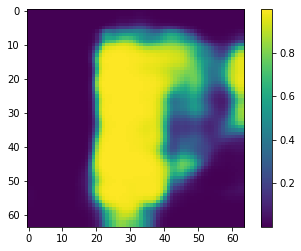

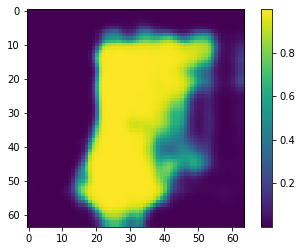

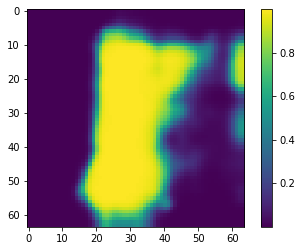

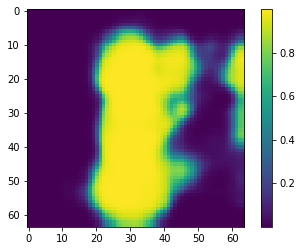

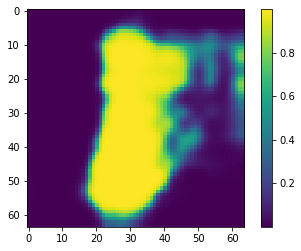

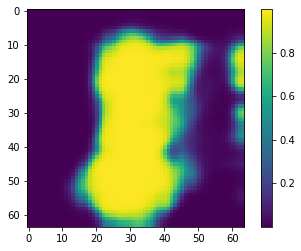

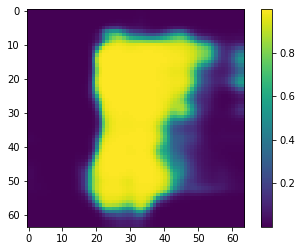

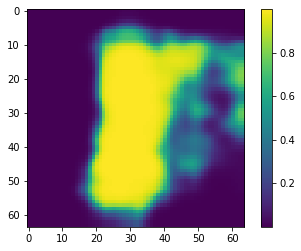

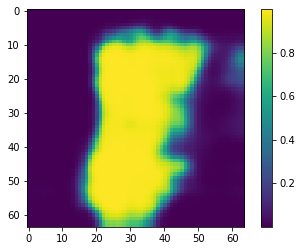

In [14]:
#@title Infer on test set
out_mask = None
loader = data_module.test_dataloader()
out_masks=[]
for i,batch in enumerate(loader):
  out_mask = slime.predict_step(batch,i).cpu().numpy()
  out_masks.append(out_mask)

import matplotlib.pyplot as plt
for out_mask in out_masks:
  for j in range(len(out_mask)):
    plt.imshow(sigmoid(out_mask[j,:,1].reshape((64,64))))
    plt.colorbar()
    plt.show()

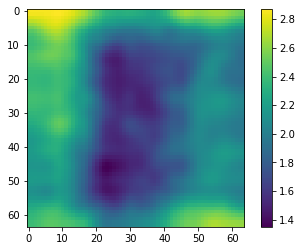

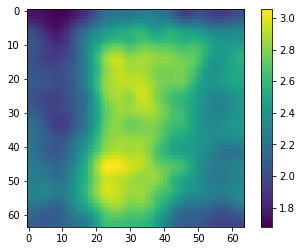

tensor([0.3275, 0.6064, 0.6064, 0.6064, 0.6064, 0.6064, 0.6064, 0.6064, 0.6064,
        0.6064, 0.6064, 0.6064, 0.6064, 0.6064, 0.6064, 0.6064],
       device='cuda:0')


In [15]:
preds = slime.latest_means
# print([(pred.shape,pred.mean(axis=1)) for pred in preds])

for pred in preds:
    for i in range(pred.shape[1]):
        plt.imshow(pred[0,i].reshape((64,64)))
        plt.colorbar()
        plt.show()

print(slime.cross_layer_multiplier.weight.data)

[(20, 256, 4)]
Layer 0


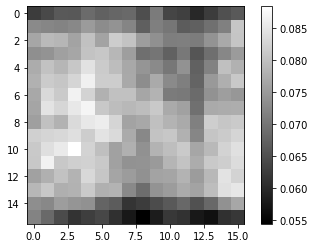

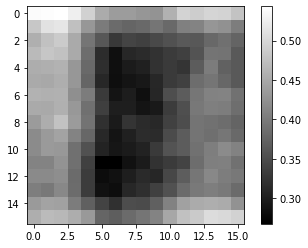

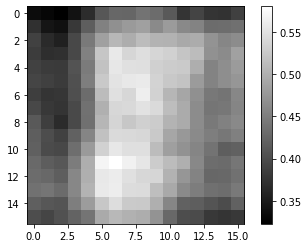

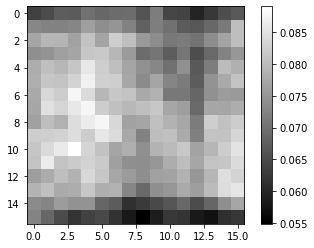

tensor([0.3275, 0.6064, 0.6064, 0.6064, 0.6064, 0.6064, 0.6064, 0.6064, 0.6064,
        0.6064, 0.6064, 0.6064, 0.6064, 0.6064, 0.6064, 0.6064],
       device='cuda:0')


In [16]:
xattns = slime.latest_xattns
print([(xattn.shape) for xattn in xattns])

for i,xattn in enumerate(xattns):
    print("Layer",i)
    img_tokens = xattn.shape[1]
    img_dim = int(math.sqrt(img_tokens))
    reshaped = xattn.mean(axis=0,keepdims=True).reshape((img_dim,img_dim,-1))
    for j in range(reshaped.shape[-1]):
        plt.imshow(reshaped[...,j],cmap="gray")
        plt.colorbar()
        plt.show()

print(slime.cross_layer_multiplier.weight.data)

In [17]:
!cd /content/slime-experiments/ && git diff

/bin/bash: line 0: cd: /content/slime-experiments/: No such file or directory
